In [36]:
# Note book to compute and display total demand (i.e., for all modes) in "external" TAZes

import openmatrix as omx
import numpy as np
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as plt
import bokeh
import xarray as xr
import hvplot.pandas
import hvplot.xarray

In [37]:
# Root directory for MoDX output for "base year" model results.
#
base_scenario_dir = r'G:/Regional_Modeling/1A_Archives/LRTP_2018/2016 Scen 00_08March2019_MoDXoutputs/'
#
# Root directory for MoDX output for "comparison scenario" model results.
# 
comparison_scenario_dir = r'G:/Regional_Modeling/1A_Archives/LRTP_2018/2040 NB Scen 01_MoDXoutputs/'

In [38]:
# ===>>>USER INPUT REQUIRED: <<<===
#
# Supply path to root directory of scenario to use for the current run of this notebook:
# 
home_dir = base_scenario_dir
# 
# 2. Supply path to root of user's "sandbox" directory:
#
my_sandbox_dir = r'S:/my_modx_output_dir/'
#
# 3. Supply name of CSV output file for tabular results generated by this notebook:
#
csv_output_fn = 'demand_in_external_tazs_report_base.csv'

In [39]:
taz_shapefile_base_dir = r'G:/Data_Resources/modx/canonical_TAZ_shapefile/'

In [40]:
# trip_tables directory - this really "should" be a subdirectory of the base directory, but is isn't currently.
# The real McCoy - where things should go, and will eventually go
tt_dir = home_dir + 'out/'

In [41]:
# trip tables OMX file (matrices)
tt_am = tt_dir + 'AfterSC_Final_AM_Tables.omx'
tt_md = tt_dir + 'AfterSC_Final_MD_Tables.omx'
tt_pm = tt_dir + 'AfterSC_Final_PM_Tables.omx'
tt_nt = tt_dir + 'AfterSC_Final_NT_Tables.omx'
trip_tables = { 'am' :  omx.open_file(tt_am, 'r'),
                'md' : omx.open_file(tt_pm, 'r'),
                'pm' : omx.open_file(tt_pm,'r'),
                'nt'  : omx.open_file(tt_nt, 'r') }

In [42]:
num_tazes = trip_tables['am'].shape()[0]

In [43]:
# Mapping from TAZ-ID to OMX index for the 4 periods (these *should* be the same)
taz_to_omxid_am = trip_tables['am'].mapping('ID')
taz_to_omxid_am = trip_tables['md'].mapping('ID')
taz_to_omxid_pm = trip_tables['pm'].mapping('ID')
taz_to_omxid_nt =  trip_tables['nt'].mapping('ID')

In [44]:
# We'll assume that the mapping from TAZ ID to OMX ID doesn't vary by time period.
# We'll use the AM mapping as _the_ mapping for all time periods, pending confirmation.
# 
# TBD: Insert "sanity check" that the 4 mappings on "ID" are identical.
#
taz_to_omxid = taz_to_omxid_am

In [45]:
# Function: tt_total_for_mode
#
# Summary: Return the total travel demand, over all i and j, from TAZ[i] to TAZ[j] for the specified mode.
#
# Given the OMX trip tables for the 4 time periods and a mode,
# return an numpy array with the "numpy sum" of the data in the OMX array for the 4 time periods.
def tt_total_for_mode(tts, mode):
	am = tts['am'][mode]
	md = tts['md'][mode]
	pm = tts['pm'][mode]
	nt =  tts['nt'][mode]
	# Convert OMX arrays into numpy arrays
	am_np = np.array(am)
	md_np = np.array(md)
	pm_np = np.array(pm)
	nt_np = np.array(nt)
	total = am_np + md_np + pm_np + nt_np
	return total
# end_def tt_total_for_mode

In [46]:
# Function to generate the calculation to total demand for a list of modes.
# Return a dictionary containing the total demand for each mode, with the key value == the mode name
def tt_totals_for_mode_list(tts, mode_list):
    retval = {}
    for mode in mode_list:
        temp = tt_total_for_mode(tts, mode)
        retval[mode] = temp
    #
    return retval
# end_def tt_total_for_mode_list

In [47]:
# *** Careful about running this ... it is a large hammer!
# It would be better to have factored out all but the external TAZes from the trip_tables to begin with...
# Haven't yet figured out a good/clean way to do that...
#
mode_list = ['SOV', 'HOV', 'Heavy_Truck', 'Heavy_Truck_HazMat', 'Medium_Truck', 'Medium_Truck_HazMat', 'Light_Truck',
             'Walk', 'Bike', 'DAT_Boat', 'DET_Boat', 'DAT_CR', 'DET_CR', 'DAT_LB', 'DET_LB', 'DAT_RT', 'DET_RT', 'WAT' ]
all_modes = tt_totals_for_mode_list(trip_tables, mode_list)

sum_all_modes = all_modes['SOV'] + all_modes['HOV'] + \
                all_modes['Heavy_Truck'] + all_modes['Heavy_Truck_HazMat'] + \
                all_modes['Medium_Truck'] + all_modes['Medium_Truck_HazMat'] + \
                all_modes['Light_Truck'] + \
                all_modes['DAT_Boat'] + all_modes['DET_Boat'] +  \
                all_modes['DAT_CR'] + all_modes['DET_CR'] + \
                all_modes['DAT_LB'] + all_modes['DET_LB'] + \
                all_modes['DAT_RT'] + all_modes['DET_RT'] + \
                all_modes['WAT']

In [48]:
sum_all_modes_by_origin = sum_all_modes.sum(axis=1)

In [49]:
# Build a data frame, indexed by omxid, containing the  trips originating in each TAZ:
total_all_modes_trips_df = pd.DataFrame(sum_all_modes_by_origin, columns=['total_demand_all_modes'])
# Set the data frame's index to the omxid of each row, i.e., its index
total_all_modes_trips_df['omxid'] = total_all_modes_trips_df.index
total_all_modes_trips_df.set_index('omxid')

,total_demand_all_modes
omxid,
0,6788.524414
1,6442.856445
2,12086.071289
3,5334.669922
4,3634.364502
...,...
5834,1076.660889
5835,1894.692017
5836,1076.859131


In [50]:
# A bit of a digression here, for the time being...
# Load the candidate canonical TAZ shapefile as a geopands dataframe
taz_shapefile = taz_shapefile_base_dir + 'candidate_CTPS_TAZ_STATEWIDE_2019.shp'
taz_gdf = gp.read_file(taz_shapefile)
taz_gdf.set_index("id")

,OBJECTID,taz,type,town,state,town_state,mpo,in_brmpo,subregion,Shape_Leng,Shape_Area,geometry
id,,,,,,,,,,,,
4398,1,0,I,MIDDLEBOROUGH,MA,"MIDDLEBOROUGH,MA",SRPEDD,0,None,22284.463348,2.016745e+07,"POLYGON ((246729.399 855385.952, 246722.789 85..."
2571,2,1,I,BRIDGEWATER,MA,"BRIDGEWATER,MA",OCPC,0,None,18241.697275,9.283492e+06,"POLYGON ((247846.936 856739.950, 247846.689 85..."
2669,3,2,I,HALIFAX,MA,"HALIFAX,MA",OCPC,0,None,17900.674759,1.605829e+07,"POLYGON ((249688.220 857104.527, 249688.219 85..."
4392,4,3,I,MIDDLEBOROUGH,MA,"MIDDLEBOROUGH,MA",SRPEDD,0,None,23735.098952,1.992132e+07,"POLYGON ((251073.143 851003.537, 251079.003 85..."
2641,5,49,I,MARSHFIELD,MA,"MARSHFIELD,MA",BRMPO,1,SSC,19458.111922,4.236088e+06,"POLYGON ((264256.501 872054.207, 264263.627 87..."
...,...,...,...,...,...,...,...,...,...,...,...,...
4793,5835,5834,I,TRURO,MA,"TRURO,MA",CCC,0,None,20079.041945,1.255120e+07,"POLYGON ((316444.839 865421.738, 316453.465 86..."
4795,5836,5835,I,TRURO,MA,"TRURO,MA",CCC,0,None,25698.527422,2.833193e+07,"POLYGON ((318817.510 861617.242, 318782.355 86..."
4794,5837,5836,I,PROVINCETOWN,MA,"PROVINCETOWN,MA",CCC,0,None,2836.977271,4.858583e+05,"POLYGON ((308522.256 868439.668, 308587.408 86..."


In [51]:
# Add a 'omxid' column to the TAZ geodataframe, and 'calc' in the corresponding omxid value,
# in prep for joining with the total trips dataframe.
taz_gdf['omxid'] = taz_gdf.apply(lambda row: taz_to_omxid[row.id], axis=1)

In [52]:
# Join the shapefile geodataframe to the total trips dataframe on 'omxid'
joined_df = taz_gdf.join(total_all_modes_trips_df.set_index('omxid'), on='omxid')

In [53]:
# Extract the rows for external TAZes:
#
# *** WARNING - TEMPORARY HACK HERE !!! ***
#
first_external_taz = 209001
external_taz_gdf = joined_df[joined_df['id'] >= first_external_taz]

In [54]:
external_taz_gdf

,OBJECTID,id,taz,type,town,state,town_state,mpo,in_brmpo,subregion,Shape_Leng,Shape_Area,geometry,omxid,total_demand_all_modes
2984,2985,209100,2708,E,STONINGTON,CT,"STONINGTON,CT",None,0,None,6169.439827,1.783118e+06,"POLYGON ((170587.186 793244.783, 168761.138 79...",5838,8172.249512
2999,3000,209095,2707,E,KILLINGLY,CT,"KILLINGLY,CT",None,0,None,7515.249749,2.581509e+06,"POLYGON ((174882.551 837034.811, 172364.861 83...",5833,5381.612305
3011,3012,209098,2752,E,VOLUNTOWN,CT,"VOLUNTOWN,CT",None,0,None,2961.935536,3.803287e+05,"POLYGON ((175227.519 810875.763, 174088.044 81...",5836,1076.859131
3012,3013,209099,2753,E,NORTH STONINGTON,CT,"NORTH STONINGTON,CT",None,0,None,5625.738330,1.482115e+06,"POLYGON ((174906.641 797986.038, 173096.928 79...",5837,49748.187500
3013,3014,209097,2754,E,VOLUNTOWN,CT,"VOLUNTOWN,CT",None,0,None,2849.802272,3.897250e+05,"POLYGON ((174954.719 811883.330, 174090.112 81...",5835,1894.692017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5822,5823,209001,5822,E,KITTERY,ME,"KITTERY,ME",None,0,None,1964.585111,1.849201e+05,"POLYGON ((261415.697 981338.560, 260965.153 98...",5739,5583.983398
5823,5824,209002,5823,E,KITTERY,ME,"KITTERY,ME",None,0,None,2018.914126,1.749990e+05,"POLYGON ((260561.861 982073.153, 260189.282 98...",5740,9681.109375
5828,5829,209003,5828,E,KITTERY,ME,"KITTERY,ME",None,0,None,2487.910895,2.885700e+05,"POLYGON ((259983.779 983012.334, 259318.390 98...",5741,45234.132812
5837,5838,209094,5837,E,KILLINGLY,CT,"KILLINGLY,CT",None,0,None,6486.571441,2.003195e+06,"POLYGON ((174204.649 843436.151, 172797.608 84...",5832,2555.241455


In [55]:
# Export the useful columns of data in the 'external_taz_gdf' dataframe as a CSV file
fq_output_fn = my_sandbox_dir + csv_output_fn
external_taz_gdf.to_csv(fq_output_fn, sep=',', columns=['id', 'town', 'state', 'total_demand_all_modes'])

<AxesSubplot:title={'center':'Number of Trips from External TAZes'}, ylabel='TAZ ID'>

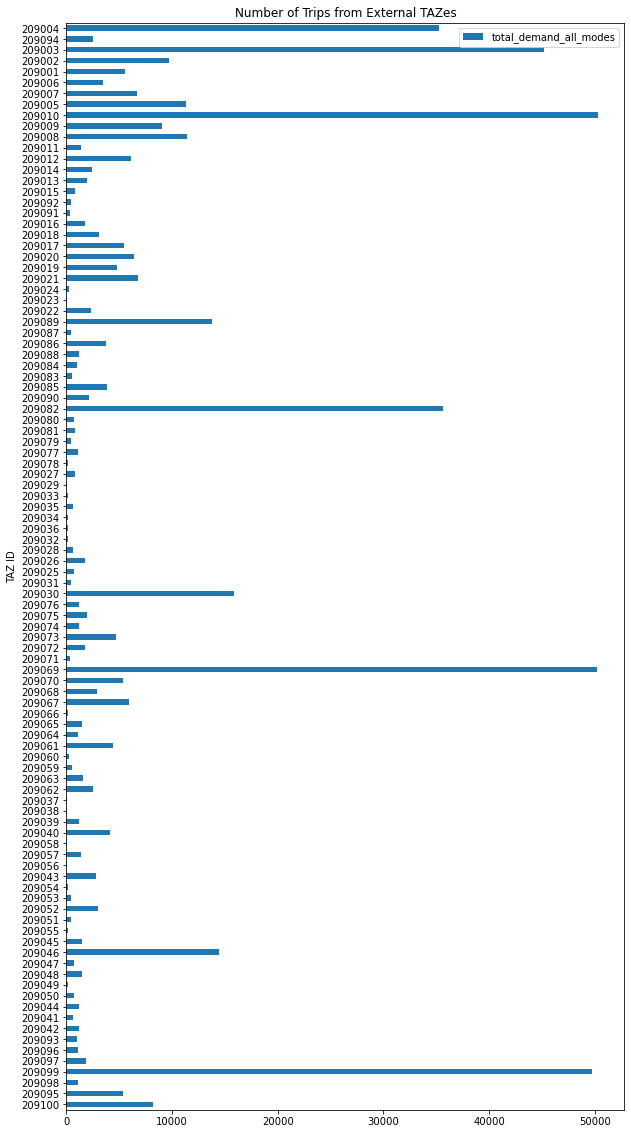

In [56]:
# Make a static horizontal bar chart of the data
temp_df = external_taz_gdf[['id', 'town_state','total_demand_all_modes']]
#
plt.rcParams["figure.figsize"] = (10,20)
#
temp_df.plot.barh(x='id', 
                  y='total_demand_all_modes', 
                  xlabel='TAZ ID',
                  ylabel='Number of Trips', 
                  title='Number of Trips from External TAZes')

In [57]:
# Make an interactive bar chart of the same information 
temp_df.hvplot.barh(x='id', 
                    xlabel='Origin TAZ', 
                    y='total_demand_all_modes', 
                    ylabel='Total Demand', 
                    xformatter="%f", 
                    hover_cols='all',
                    frame_width=500,
                    frame_height=1000)

:Bars   [id]   (total_demand_all_modes,index,town_state)